# TP Deep Clustering 


<img src="https://drive.google.com/uc?id=13dN55x2iT_Y29SRkq4748SxaYLfgt_Kp" width="1200">


L'objectif de ce TP consiste à créer un modèle constitué de plusieurs parties :

- Un auto-codeur, pré-entraîné pour apprendre la représentation condensée initiale des jeux de données non étiquetés.
- Une couche de clustering empilée sur l'encodeur pour affecter la sortie de l'encodeur à un cluster. Les poids de la couche de clustering sont initialisés avec les centres de cluster de K-Means basés sur l'évaluation actuelle.
- Entraîner le modèle de clustering pour affiner la couche de clustering et le codeur conjointement.


In [1]:
from time import time
import numpy as np
import keras.backend as K
from keras.layers import Dense, Input, Layer, InputSpec,  Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2023-10-05 16:29:09.273472: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 16:29:09.324133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 16:29:10.026510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Chargement des données

In [2]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist # à tester, + complexe que l'ensemble mnist 

import numpy as np

# Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST/Fashion mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_trainIm = x_train.astype('float32') / 255.
x_testIm = x_test.astype('float32') / 255.

x_train = np.reshape(x_trainIm, (len(x_train), 784))
x_test = np.reshape(x_testIm, (len(x_test), 784))

# Nombre de classes à trouver
n_clusters=10

# Baseline par clustering classique par kmeans

In [3]:
# nombre de chiffres
n_digits = len(np.unique(y_test))

# Initialisation du Kmeans 
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Appliquer Kmeans sur base d'apprentissage
y_pred_kmeans=kmeans.fit_predict(x_train)

/home/mickael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [4]:
# Score de performance
accuracy_score(y_train, y_pred_kmeans)

0.15646666666666667

## Attribution des étiquettes de cluster

La classification K-means est une méthode d'apprentissage automatique non supervisée ; par conséquent, les étiquettes attribuées par notre algorithme KMeans font référence à la classification à laquelle chaque tableau a été attribué, et non à l'entier cible réel. Pour résoudre ce problème, définissons quelques fonctions qui prédiront quel nombre entier correspond à chaque cluster.

In [5]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label 
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

In [6]:
def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


In [ ]:
# Score de performance sur l'apprentissage après correspondance entre les classes
# A COMPLETER

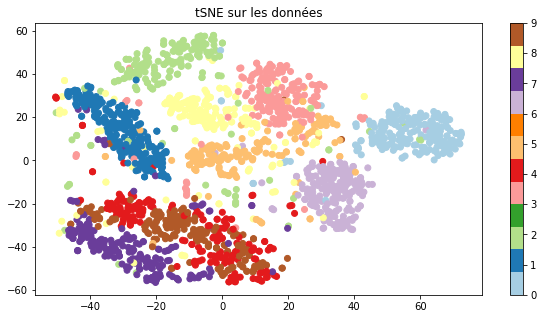

In [7]:
# Affichage des données 
count=2000
ListeData = np.random.choice(len(x_test), count)
inputs = x_train[ListeData]
classes = y_train[ListeData]

# Appliquer une réduction de données en 2D via la TSNE
# A COMPLETER
count = 2000
ListData = np.random.choice(len(x_test), count)
inputs = x_train[ListeData]
classes = y_train[ListeData]

coordsTSNE = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))

plt.figure(figsize=(10,5))
plt.title("tSNE sur les données")
plt.scatter(coordsTSNE[:,0],coordsTSNE[:,1], c = classes, cmap='Paired')
plt.colorbar()

# Autoencodeur classique à définir 

In [11]:
# Architecture de l'autoencodeur
# à coder
def build_autoencoder(n_latent = 32):
    # Dimension de l'entrée
    input_img = Input(shape=(784,))

    # Définition de l'encoder
    x = Dense(128, activation='relu')(input_img)
    encoded = Dense(n_latent, activation='linear')(x)
    encoder = Model(input_img, encoded, name = "encoder")

    # Définition du decoder
    decoder_input = Input(shape=(n_latent,))
    x = Dense(128, activation='relu')(decoder_input)
    decoded = Dense(784, activation='sigmoid')(x)
    decoder = Model(decoder_input, decoded, name = "decoder")

    # Construction de l'auto-encodeur
    encoded = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder = Model(input_img, decoded, name = "autoencoder")

    return autoencoder, encoder, decoder


In [16]:
# Autoencodeur summary
# à coder

autoencoder, encoder, decoder = build_autoencoder()
autoencoder.summary()
autoencoder.compile(optimizer="Adam",loss = 'MSE')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 32)                104608    
                                                                 
 decoder (Functional)        (None, 784)               105360    
                                                                 
Total params: 209968 (820.19 KB)
Trainable params: 209968 (820.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Entraînement de l'autoencodeur 

In [17]:
# Entraînement de l'autoencodeur 
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25
469/469 [==============================] - 3s 4ms/step - loss: 0.0397 - val_loss: 0.0188
Epoch 2/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0156 - val_loss: 0.0128
Epoch 3/25
469/469 [==============================] - 2s 3ms/step - loss: 0.0121 - val_loss: 0.0109
Epoch 4/25
469/469 [==============================] - 2s 3ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 5/25
469/469 [==============================] - 2s 3ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 6/25
469/469 [==============================] - 2s 3ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 7/25
469/469 [==============================] - 2s 3ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 8/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 9/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 10/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0082 - val_loss: 0.0079

In [25]:
import random 

In [36]:
def vizualise (x_test,imgs,sz=(28,28)) :
    n = 10
    idx = [random.randint(0, x_test.shape[0]) for _ in range(0, n)]

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[idx[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i+1 + n)
        plt.imshow(imgs[idx[i]].reshape(sz))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


313/313 [==============================] - 0s 1ms/step


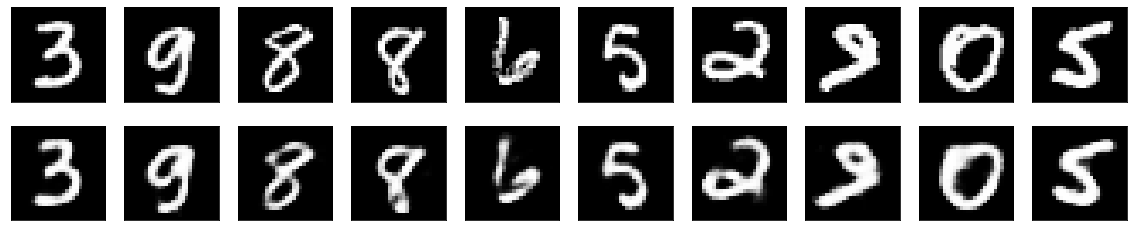

In [37]:
# Encoder et décoder quelques chiffres de l'ensemble test
img = autoencoder.predict(x_test)
vizualise(x_test, img)

313/313 [==============================] - 0s 811us/step


ValueError: cannot reshape array of size 784 into shape (32,32)

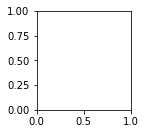

In [35]:
n = 20  # Combien de chiffres nous allons afficher

# Afficher l'image reconstruite à partir de l'espace latent après entraînement
# À COMPLÉTER
espace_latent = encoder.predict(x_test)
vizualise(x_test, espace_latent)


In [ ]:
# Affichage de l'espace latent par réduction de dimension 
count=2000
inputs = x_train[ListeData]
classes = y_train[ListeData]

# Récupération des données dans l'espace latent
data_espace_latent = encoder.predict(inputs)
# Réduction de dimension 2D par ACP


# Réduction de dimension 2D par la TSNE


# Affichage de l'espace latent par ACP et TSNE


In [ ]:
# Classification par kmeans de l'espace latent sur l'ensemble d'apprentissage

# Initialisation du Kmeans 
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Affichage
inputsTrain = x_train
classesTrain = y_train


# Kmeans sur base d'apprentissage

# Score de performance sur l'apprentissage

print("Performance de l'autoencodeur : accuracy sur kmeans sur l'espace latent")


## Couche de clustering 
maintient les centres de cluster $\mu_j$ comme poids entraînables et projette chaque point intégré $z_i$ en soft label $q_i$ par la distribution $t$ de Student:
$$q_{ij}=\frac{(1+\|z_i-\mu_j\|^2)^{-1}}{\sum_j(1+\|z_i-\mu_j\|^2)^{-1}}$$
où $q_{ij}$ est la $j$ième entrée de $q_i$, représentant la probabilité d'appartenance de $z_i$ au cluster $j$.

In [ ]:
class ClusteringLayer(Layer):
    """
    La couche de classification convertit l'échantillon d'entrée (caractéristique) en une étiquette souple, c'est-à-dire un vecteur qui représente la probabilité d'appartenance de l'échantillon à chaque groupe.
    probabilité d'appartenance de l'échantillon à chaque cluster. La probabilité est calculée avec la distribution t de student.
    # Exemple
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters : nombre de clusters.
        weights : liste de tableaux Numpy de forme `(n_clusters, n_features)` qui représente les centres de clusters initiaux.
        alpha : paramètre de la distribution t de Student. La valeur par défaut est 1.0.
    # Forme de l'entrée
        Tenseur 2D avec la forme : `(n_samples, n_features)`.
    # Forme en sortie
        Tenseur 2D avec forme : `(n_samples, n_clusters)`.
    """


    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
      """ Distribution t de student, la même que celle utilisée dans l'algorithme t-SNE.
                 q_ij = 1/(1+dist(x_i, u_j)^2), puis normalisation.
        Arguments :
            inputs : la variable contenant les données, shape=(n_samples, n_features)
        Retourne :
            q : la distribution t de student, ou des étiquettes souples pour chaque échantillon. shape=(n_samples, n_clusters)
        """
      q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
      q **= (self.alpha + 1.0) / 2.0
      q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
      return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Définition de la distribution $P$ cible définie comme
$$p_{ij}=\frac{q_{ij}^2/\sum_i q_{ij}}{\sum_j (q_{ij}^2/\sum_i q_{ij})}.$$
où $p_{ij}$ est la $j$ième entrée de $p_i$ représentant la probabilité d'appartenance de la donnée $i$ la classe $j$

In [ ]:
# Calcul de la distribution cible
def target_distribution(q):
  # à compléter
    return 0

In [ ]:
# Configuration de la couche de clustering
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

model.compile(optimizer="Adam", loss='kld')

# Entrainement du modèle avec la couche de clustering

In [ ]:
# paramètres à fixer
loss = 0
index = 0
maxiter =4000
update_interval = 140
batch_size=128
index_array = np.arange(x_train.shape[0])
tol = 0.005 # seuil pour critère d'arrêt

In [ ]:
#Initialisation Kmeans
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))

# récupération des centres de clusters   
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x_train, verbose=0)
        p = target_distribution(q)  # mise à jour de la distribution cible p 

        # evaluation de la performance du clustering 
        y_pred = q.argmax(1)
        if y_train is not None: 
            y_pred=correspondance(y_pred,y_train)
            acc = np.round(accuracy_score(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('(Iter , acc)  ',(ite, acc), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    loss = model.train_on_batch(x=x_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0

In [ ]:
# Affichage de l'impact de cette couche clustering 

inputs = x_train[ListeData]
classes = y_train[ListeData]

# TSNE sur espace latent avec kmeans
coordsAC_V2 = encoder.predict(inputs)
coordsTSNE_V2 = TSNE(n_components=2).fit_transform(coordsAC_V2.reshape(count, -1))


fig2= plt.figure(figsize=(30, 10))
ax2=plt.subplot(1,3,1)
ax2.set_title("TSNE sur MNIST")
plt.scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=classes,cmap='Paired')
plt.colorbar()


ax2 = plt.subplot(1,3,2)
ax2.set_title("tSNE sur espace latent")
plt.scatter(coordsTSNE_AC[:, 0], coordsTSNE_AC[:, 1], c=classes,cmap='Paired')
plt.colorbar()



ax2 = plt.subplot(1,3,3)
ax2.set_title("tSNE après clustering sur espace latent")
plt.scatter(coordsTSNE_V2[:, 0], coordsTSNE_V2[:, 1], c=classes,cmap='Paired')
plt.colorbar()

# Passer à la version convolutive de l'autoencodeur